---
title: "SWD Properties"
format:
  html:
    code-fold: true
output-file: properties.html

---

In [614]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [615]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np

from loguru import logger

In [616]:
#| output: False
from ids_finder.utils.basic import load_catalog

catalog = load_catalog('../../')

[11/02/23 09:30:42] WARNING  /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/ke ]8;id=559644;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=512449;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             dro/io/partitioned_dataset.py:200: KedroDeprecationWarning:                           
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

Connect `python` with `R` kernel

In [617]:
%load_ext rpy2.ipython
from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects
r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Loading all datasets from different sources

In [618]:
from ids_finder.candidates import cIDsDataset

sta_dataset = cIDsDataset(sat_id="STA", tau=60, ts=1, catalog=catalog)
jno_dataset = cIDsDataset(sat_id="JNO", tau=60, ts=1, catalog=catalog)
thb_dataset = cIDsDataset(sat_id="THB", tau=60, ts=1, catalog=catalog)

                    INFO     Loading data from 'candidates.STA_ts_1s_tau_60s'                   ]8;id=44460;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=119335;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'STA.primary_mag_ts_1s' (PartitionedDataset)...  ]8;id=344185;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=963045;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'candidates.JNO_ts_1s_tau_60s'                   ]8;id=897728;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=775577;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'JNO.primary_mag_ts_1s' (PartitionedDataset)...  ]8;id=547088;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=423508;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'candidates.THB_ts_1s_tau_60s'                   ]8;id=337652;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=129049;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'THB.primary_mag_ts_1s' (PartitionedDataset)...  ]8;id=597618;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=554326;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [619]:
from beforerr.basics import pmap
from ids_finder.utils.analysis import filter_tranges_ds


In [620]:
thb_inter_state_sw: pl.LazyFrame = catalog.load('thb.inter_state_sw')
start, end = thb_inter_state_sw.select(['start', 'end']).collect()

thb_sw_dataset = filter_tranges_ds(thb_dataset, (start, end))

                    INFO     Loading data from 'thb.inter_state_sw' (LazyPolarsDataset)...      ]8;id=490876;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=90089;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [621]:
all_datasets = [sta_dataset, jno_dataset, thb_sw_dataset]

In [622]:
all_candidates_l0 : pl.DataFrame = pl.concat(
    all_datasets | pmap(lambda x: x.candidates),
    how="diagonal",
)

## Processing datasets

Some extreme values are present in the data. We will remove them.

In [623]:

NVARS = ['d_star', 'L_mn', 'L_mn_norm', 'j0', 'j0_norm', 'duration', 'v_mn']
DISPLAY_VARS = ['time', 'sat'] + NVARS


def check_candidates(df):
    return df[NVARS].describe()

check_candidates(all_candidates_l0)

describe,d_star,L_mn,L_mn_norm,j0,j0_norm,duration,v_mn
str,f64,f64,f64,f64,f64,str,f64
"""count""",185066.0,185066.0,185066.0,185066.0,185066.0,"""185066""",185066.0
"""null_count""",0.0,4120.0,4389.0,4120.0,4389.0,"""0""",4120.0
"""mean""",2.611712,2798.843381,22.307474,11.654787,4.713652,"""0:00:08.198437…",343.811034
"""std""",491.756741,2179.474212,20.649185,2894.040891,1473.838227,null,99.930132
"""min""",0.019601,3.381065,0.014144,0.0561,0.00082,"""0:00:01.999999…",0.41411
"""25%""",0.247087,1582.102536,11.284664,0.601477,0.028203,"""0:00:05""",286.126017
"""50%""",0.510951,2240.279834,17.513617,1.239019,0.051221,"""0:00:07""",343.325961
"""75%""",0.983944,3346.020528,27.236719,2.34897,0.091488,"""0:00:10""",402.282733
"""max""",152023.367594,103745.212024,1614.132093,1.1500e6,583059.205803,"""0:03:16""",864.604665


In [624]:
from datetime import timedelta

def process_candidates_l1(raw_df: pl.DataFrame):
    "clean data to remove extreme values"

    df = raw_df.filter(
        pl.col("d_star") < 100, # exclude JUNO extreme values
        pl.col('v_mn') > 10,
        pl.col('duration') < timedelta(seconds=60),
        # pl.col("j0") < 100
    )

    logger.info(
        f"candidates_l1: {len(df)}, with effective ratio: {len(df) / len(raw_df):.2%}"
    )

    return df

all_candidates_l1 = process_candidates_l1(all_candidates_l0)
check_candidates(all_candidates_l1)

2023-11-02 09:30:45.987 | INFO     | __main__:process_candidates_l1:13 - candidates_l1: 180718, with effective ratio: 97.65%


describe,d_star,L_mn,L_mn_norm,j0,j0_norm,duration,v_mn
str,f64,f64,f64,f64,f64,str,f64
"""count""",180718.0,180718.0,180718.0,180718.0,180718.0,"""180718""",180718.0
"""null_count""",0.0,0.0,264.0,0.0,264.0,"""0""",0.0
"""mean""",0.745751,2768.506268,22.033678,1.865352,0.075518,"""0:00:08.118150…",343.880697
"""std""",0.771981,1909.065522,17.629565,2.599027,0.097857,null,99.846681
"""min""",0.019601,48.94197,0.124168,0.0561,0.00082,"""0:00:01.999999…",10.240242
"""25%""",0.243875,1581.58393,11.279769,0.60174,0.028229,"""0:00:05""",286.190021
"""50%""",0.50421,2238.553736,17.499906,1.239576,0.051251,"""0:00:07""",343.360031
"""75%""",0.97075,3340.552536,27.186555,2.348456,0.091501,"""0:00:10""",402.301723
"""max""",13.805873,35975.767016,439.323024,393.479096,9.634978,"""0:00:59""",864.604665


In [625]:
jno_candidates_l1 = all_candidates_l1.filter(pl.col('sat') == 'JNO')

In [626]:
from ids_finder.utils.analysis import filter_before_jupiter
from ids_finder.utils.analysis import link_coord2dim

In [627]:
def process_candidates_l2(raw_df: pl.DataFrame, avg_window="30d"):
    time_col = "time"

    candidate = (
        raw_df.sort(time_col)
        .group_by_dynamic(time_col, every=avg_window, by="sat")
        .agg(cs.numeric().mean(), cs.duration().mean(), id_count=pl.count())
        .filter(pl.col("id_count") > 50)  # filter out JUNO extreme large thickness
        .sort(time_col)
        .upsample(time_col, every=avg_window, by="sat", maintain_order=True)
        .with_columns(pl.col("sat").forward_fill())
    )
    return candidate

In [628]:
all_candidates_l2: pl.DataFrame = (
    all_candidates_l1.pipe(filter_before_jupiter)
    .pipe(process_candidates_l2)
    .pipe(link_coord2dim)
)

In [629]:
inspect_df = all_candidates_l2[NVARS]
inspect_df.describe()

describe,d_star,L_mn,L_mn_norm,j0,j0_norm,duration,v_mn
str,f64,f64,f64,f64,f64,str,f64
"""count""",172.0,172.0,172.0,172.0,172.0,"""172""",172.0
"""null_count""",19.0,19.0,19.0,19.0,19.0,"""19""",19.0
"""mean""",0.706261,2922.959632,22.028999,1.937378,0.090728,"""0:00:08.719631…",337.428018
"""std""",0.358616,512.032439,8.140589,1.077249,0.051647,null,37.917741
"""min""",0.108318,1877.983131,7.074407,0.229362,0.042024,"""0:00:06.751012…",256.771354
"""25%""",0.331532,2590.280777,14.498058,0.795284,0.060267,"""0:00:07.707419…",315.324913
"""50%""",0.794667,2786.745403,22.804505,2.087583,0.069789,"""0:00:08.730158…",335.332916
"""75%""",0.931735,3182.843841,27.726721,2.633037,0.094061,"""0:00:09.315238…",359.837854
"""max""",1.539393,4458.507484,41.436617,4.784021,0.306938,"""0:00:12.305699…",445.849288


In [630]:
from ids_finder.utils.analysis import n2_normalize

all_candidates_l2_n2 = n2_normalize(all_candidates_l2, NVARS)

## Plotting function

Plotting function for Level 1 data.

Similar to the `geom_bin2d` function, but with added functionality

- Normalize the data to every x-axis value
- Add peak values
- Add mean values with error bars

In [631]:
%%R
library(scales)
# Helper function to calculate summary statistics for x-binned data
calculate_summary <- function(data, x_col, y_col, x_seq) {
  data %>%
    mutate(!!x_col := x_seq[findInterval(data[[x_col]], x_seq, rightmost.closed = TRUE)]) %>%
    group_by(!!sym(x_col)) %>%
    summarise(
      mean_y = mean(!!sym(y_col), na.rm = TRUE),
      sd_y = sd(!!sym(y_col), na.rm = TRUE),
      se_y = sd_y / sqrt(n())
    )
}


plot_binned_data <- function(data, x_col, y_col, x_bins, y_bins, y_lim=NULL, log_y=FALSE) {
  
  # If y_lim is provided, filter the data
  if (!is.null(y_lim)) {
    data <- data %>%
      filter(!!sym(y_col) >= y_lim[1], !!sym(y_col) <= y_lim[2])
  }
  
  # If transform_log_y is TRUE, transform y_col to log scale
  if (log_y) {
    data[[y_col]] <- log10(data[[y_col]])
    y_label <- paste("Log10", y_col)
  } else {
    y_label <- y_col
  }
  
  # Define bins for x and y based on the input parameters
  x_seq <- seq(min(data[[x_col]]), max(data[[x_col]]), length.out = x_bins + 1)
  y_seq <- seq(min(data[[y_col]]), max(data[[y_col]]), length.out = y_bins + 1)
  
  data_binned_normalized <- data %>%
    mutate(
      !!x_col := x_seq[findInterval(data[[x_col]], x_seq, rightmost.closed = TRUE,)],
      !!y_col := y_seq[findInterval(data[[y_col]], y_seq, rightmost.closed = TRUE,)]
    ) %>%
    count(!!sym(x_col), !!sym(y_col)) %>%
    group_by(!!sym(x_col)) %>%
    mutate(n = n/sum(n)) %>%
    ungroup()

  plot <- ggplot() +
    geom_tile(data = data_binned_normalized, aes(x = !!sym(x_col), y = !!sym(y_col), fill = n))

  # Calculate mode for each x-bin
  modes <- data_binned_normalized %>%
    group_by(!!sym(x_col)) %>%
    slice_max(n, n = 1)
    
 # Add the mode line
  plot <- plot + geom_line(data = modes, aes(x = !!sym(x_col), y = !!sym(y_col), group = 1), linetype = "dashed")

  data_xbinned <- calculate_summary(data, x_col, y_col, x_seq)
  
  plot <- plot +
    geom_errorbar(data = data_xbinned, aes(x = !!sym(x_col), ymin = mean_y - sd_y, ymax = mean_y + sd_y), width = 0.2) +
    geom_line(data = data_xbinned, aes(x = !!sym(x_col), y = mean_y))
    # Note: ggline will produce another figure, so we use geom_line instead


  plot <- plot + labs(y = y_label) + # Set y-axis label
    scale_fill_viridis_c() +
    # scale_fill_viridis_c(trans = 'log', labels = label_number(accuracy = 0.001)) +
    theme_pubr(base_size = 16, legend = "r")

  return(plot)
}

Plotting function for Level 2 averaged data.

In [632]:
%%R
# Utility function for plotting
plot_util <- function(df, x_var, y_var, y_lab, y_var_norm, y_lab_norm) {
  # Plot for the main variable
  p1 <- ggplot(df, aes(x = .data[[x_var]], y = .data[[y_var]], color = .data$sat, linetype = .data$sat)) + 
    geom_line() + geom_point() +
    labs(y = y_lab)
      
  # Plot for normalized variable
  p2 <- ggplot(df, aes(x = .data[[x_var]], y = .data[[y_var_norm]], color = .data$sat, linetype = .data$sat)) + 
    geom_line() + geom_point() +
    labs(y = y_lab_norm)

  # Common elements for plots
  common_elements <- list(
    labs(x = x_var, color="Satellites", linetype="Satellites"),
    theme_pubr(base_size = 16),
    theme(legend.text = element_text(size=16)),
    scale_color_okabeito(palette = "black_first")
  )
  
  # Apply common elements and combine the plots vertically
  p1 <- ggpar(p1 + common_elements, xlab=FALSE)
  p2 <- ggpar(p2 + common_elements, legend = "none")
  p <- p1 / p2
  
  return(p)
}

## Thickness

Note since want different y-axis titles (labels) for each facet, not different facet titles, it is not clear how to do this with `facet_wrap` after `pivot_longer`. Also these are different units, so it is better to plot them separately and combine them together.

In [633]:
%%R
plot_thickness <- function(df, x_var = "time") {
  plot_util(df, x_var, "L_mn", "Thickness (km)", "L_mn_norm", "Normalized thickness (d_i)")
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: Warning messages:
1: Removed 19 rows containing missing values (`geom_point()`). 
2: Removed 19 rows containing missing values (`geom_point()`). 
3: Removed 19 rows containing missing values (`geom_point()`). 
4: Removed 19 rows containing missing values (`geom_point()`). 
5: Removed 19 rows containing missing values (`geom_point()`). 
6: Removed 19 rows containing missing values (`geom_point()`). 


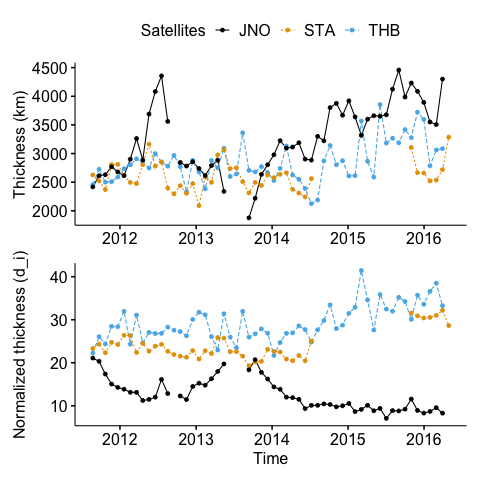

In [634]:
%%R -i all_candidates_l2 -c conv_pl
p <- plot_thickness(all_candidates_l2)
p <- ggpar(p, xlab="Time")
print(p)

save_plot("thickness_time")

In addition: Warning messages:
1: Removed 13 rows containing missing values (`geom_line()`). 
2: Removed 28 rows containing missing values (`geom_point()`). 
3: Removed 13 rows containing missing values (`geom_line()`). 
4: Removed 28 rows containing missing values (`geom_point()`). 


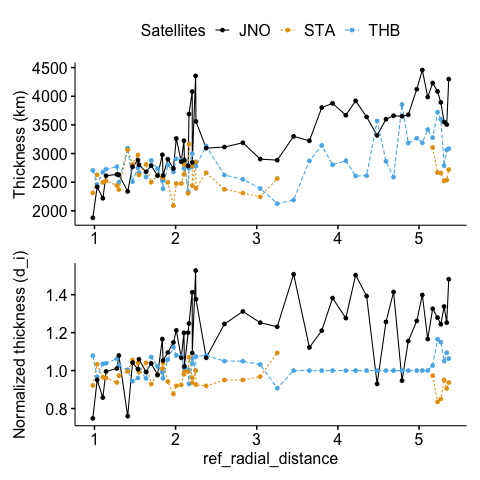

In [635]:
%%R -i all_candidates_l2_n2 -c conv_pl
plot_thickness_n2 <- function(df, x_var = "time") {
  plot_util(df, x_var, "L_mn", "Thickness (km)", "L_mn_n2", "Normalized thickness (d_i)")
}

p <- plot_thickness_n2(all_candidates_l2_n2, x_var="ref_radial_distance")
print(p)


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 12 warnings (use warnings() to see them)


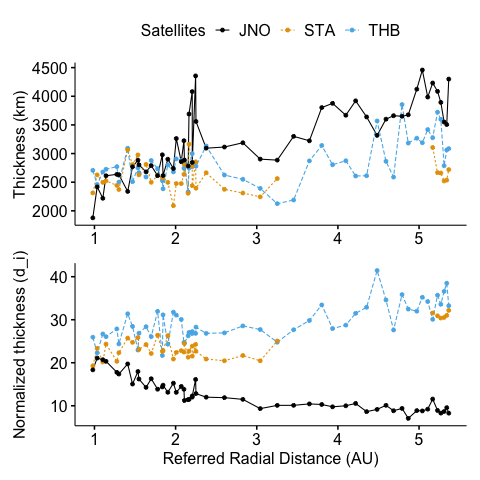

In [636]:
%%R
p <- plot_thickness(all_candidates_l2, x_var="ref_radial_distance")
p <- ggpar(p, xlab="Referred Radial Distance (AU)")
print(p)

save_plot("thickness_r")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


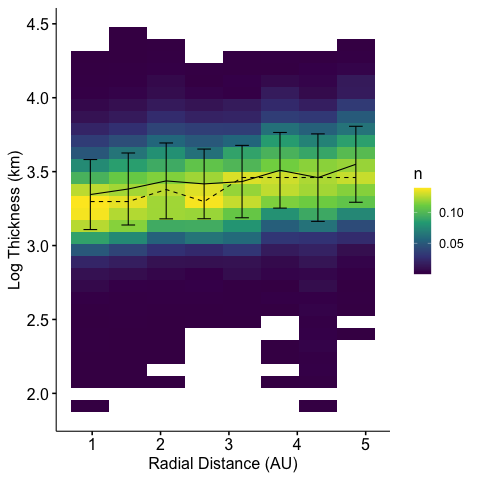

In [652]:
%%R
y_lim <- NULL
p <- plot_binned_data(jno_candidates_l1, x_col = "radial_distance", y_col = "L_mn", x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- ggpar(p, xlab="Radial Distance (AU)", ylab="Log Thickness (km)")
print(p)

save_plot("thickness_r_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


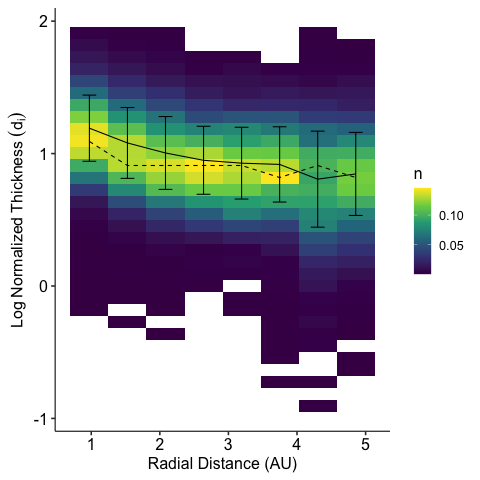

In [651]:
%%R
y_lim <- c(0,100)
p <- plot_binned_data(jno_candidates_l1, x_col = "radial_distance", y_col = "L_mn_norm", x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = "Radial Distance (AU)", y= expression(Log~Normalized~Thickness~(d[i])))
print(p)

save_plot("thickness_N1_r_dist")

## Current intensity

### Mean value

In [639]:
%%R
plot_j <- function(df, x_var = "time") {
  plot_util(df, x_var, "j0", "J (nA/m^2)", "j0_norm", "Normalized J (J_A)")
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: Warning messages:
1: Removed 19 rows containing missing values (`geom_point()`). 
2: Removed 19 rows containing missing values (`geom_point()`). 
3: Removed 19 rows containing missing values (`geom_point()`). 
4: Removed 19 rows containing missing values (`geom_point()`). 
5: Removed 19 rows containing missing values (`geom_point()`). 
6: Removed 19 rows containing missing values (`geom_point()`). 


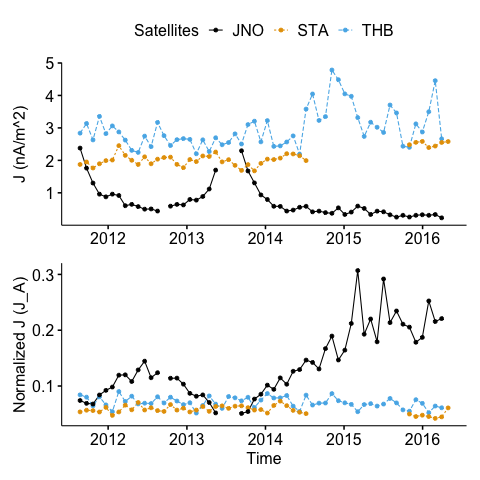

In [640]:
%%R
p <- plot_j(all_candidates_l2, x_var="time")
p <- ggpar(p, xlab="Time")
print(p)

save_plot("current_time")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 12 warnings (use warnings() to see them)


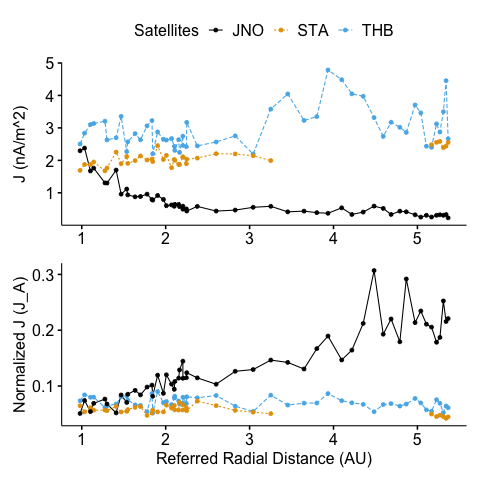

In [641]:
%%R
p <- plot_j(all_candidates_l2, x_var="ref_radial_distance")
p <- ggpar(p, xlab="Referred Radial Distance (AU)")
print(p)

save_plot("current_r")

### Map

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


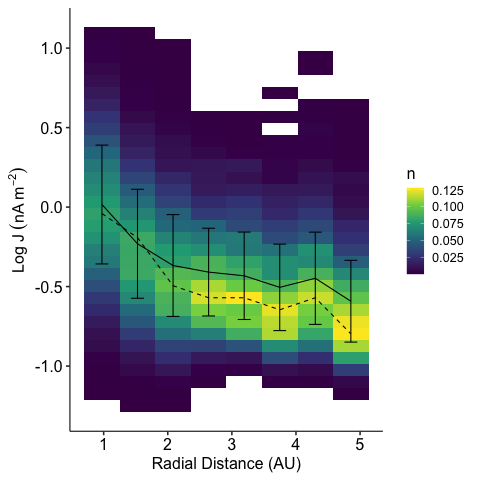

In [650]:
%%R
y_lim <- c(0, 15)
p <- plot_binned_data(jno_candidates_l1, x_col = "radial_distance", y_col = "j0", x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = "Radial Distance (AU)", y= expression(Log~J~(nA~m^-2)))
print(p)

save_plot("current_r_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


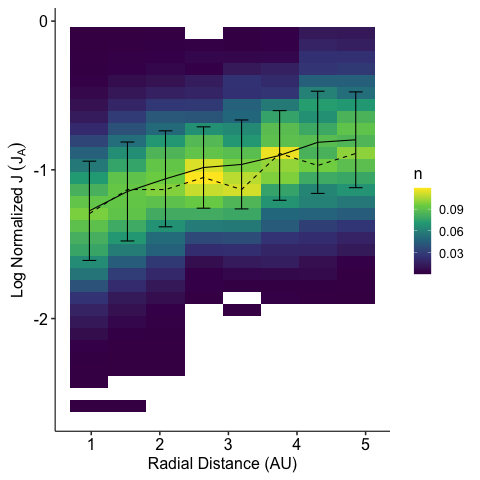

In [648]:
%%R
p<-plot_binned_data(jno_candidates_l1, x_col = "radial_distance", y_col = "j0_norm", x_bins = 8, y_bins = 32, y_lim = c(0, 1), log_y = TRUE)
p <- p + labs(x = "Radial Distance (AU)", y= expression(Log~Normalized~J~(J[A])))
print(p)

save_plot("current_N1_r_dist")

## Map of thickness and current intensity

In [644]:
%R -i all_candidates_l1 -c conv_pl

In addition: Warning messages:
1: Removed 264 rows containing non-finite values (`stat_density2d()`). 
2: Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead. 
3: Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead. 


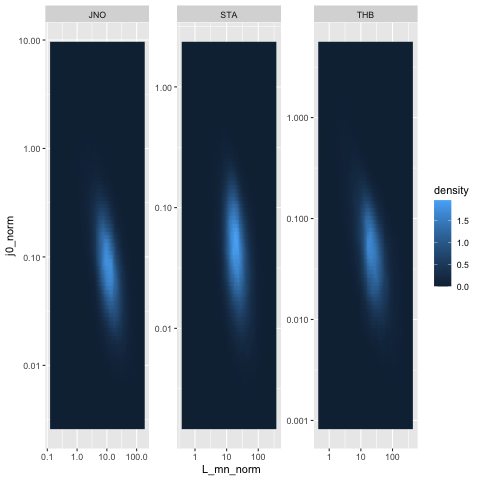

In [645]:
%%R

p <- ggplot(all_candidates_l1, aes(x = L_mn_norm, y = j0_norm)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE) +
  facet_wrap(~ sat, scales = "free") +
  scale_x_log10() + 
  scale_y_log10()

print(p)


In [646]:
%%R -i jno_candidates_l1 -c conv_pl

p <- ggplot(jno_candidates_l1, aes(x = L_mn_norm, y = j0_norm)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE) +
  facet_wrap(~ r_bin, ncol = length(unique(jno_candidates_l1$r_bin))) +
  scale_x_log10() + 
  scale_y_log10() +
  labs(fill = "Density")

print(p)


Error in `facet_wrap()`:
! `ncol` must be a whole number larger than or equal to 1 or `NULL`, not the number 0.
Run `rlang::last_trace()` to see where the error occurred.

Error in facet_wrap(~r_bin, ncol = length(unique(jno_candidates_l1$r_bin))) :


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:401 │
│ in eval                                                                                          │
│                                                                                                  │
│    398 │   │   │   try:                                                                          │
│    399 │   │   │   │   # Need the newline in case the last line in code is a comment.            │
│    400 │   │   │   │   r_expr = ri.parse(code)                                                   │
│ ❱  401 │   │   │   │   value, visible = ri.evalr_expr_with_visible(                              │
│    402 │   │   │   │   │   r_expr                                                                │
│    403 │   │   │   │   )                                                                         │
│    404 │   │   │   except (ri.embedded.RRuntimeError, ValueError) as exception:                  │
│                                                                                                  │
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface.py:196 in  │
│ evalr_expr_with_visible                                                                          │
│                                                                                                  │
│    193 │   │   │   │   │   error_occured)                                                        │
│    194 │   │   )                                                                                 │
│    195 │   │   if error_occured[0]:                                                              │
│ ❱  196 │   │   │   raise embedded.RRuntimeError(_rinterface._geterrmessage())                    │
│    197 │   │   res = conversion._cdata_to_rinterface(r_res)                                      │
│    198 │   │   assert isinstance(res, ListSexpVector)                                            │
│    199 │   return res                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RRuntimeError: Error in facet_wrap(~r_bin, ncol = length(unique(jno_candidates_l1$r_bin))) : 
  


During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 get_ipython().run_cell_magic('R', '-i jno_candidates_l1 -c conv_pl', '\np <- ggplot(jno_     │
│   2                                                                                              │
│                                                                                                  │
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/IPython/core/interactivesh │
│ ell.py:2493 in run_cell_magic                                                                    │
│                                                                                                  │
│   2490 │   │   │                                                                                 │
│   2491 │   │   │   with self.builtin_trap:                                                       │
│   2492 │   │   │   │   args = (magic_arg_s, cell)                                                │
│ ❱ 2493 │   │   │   │   result = fn(*args, **kwargs)                                              │
│   2494 │   │   │                                                                                 │
│   2495 │   │   │   # The code below prevents the output from being displayed                 

In [647]:
%%R -i jno_candidates_l1 -c conv_pl

p <- ggplot(jno_candidates_l1, aes(x = L_mn_norm, y = j0_norm)) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE) +
  facet_wrap(~ r_bin, nrow = length(unique(jno_candidates_l1$r_bin))) +
  scale_x_log10() + 
  scale_y_log10() +
  labs(fill = "Density")

print(p)


Error in `facet_wrap()`:
! `nrow` must be a whole number larger than or equal to 1 or `NULL`, not the number 0.
Run `rlang::last_trace()` to see where the error occurred.

Error in facet_wrap(~r_bin, nrow = length(unique(jno_candidates_l1$r_bin))) :


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:401 │
│ in eval                                                                                          │
│                                                                                                  │
│    398 │   │   │   try:                                                                          │
│    399 │   │   │   │   # Need the newline in case the last line in code is a comment.            │
│    400 │   │   │   │   r_expr = ri.parse(code)                                                   │
│ ❱  401 │   │   │   │   value, visible = ri.evalr_expr_with_visible(                              │
│    402 │   │   │   │   │   r_expr                                                                │
│    403 │   │   │   │   )                                                                         │
│    404 │   │   │   except (ri.embedded.RRuntimeError, ValueError) as exception:                  │
│                                                                                                  │
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/rpy2/rinterface.py:196 in  │
│ evalr_expr_with_visible                                                                          │
│                                                                                                  │
│    193 │   │   │   │   │   error_occured)                                                        │
│    194 │   │   )                                                                                 │
│    195 │   │   if error_occured[0]:                                                              │
│ ❱  196 │   │   │   raise embedded.RRuntimeError(_rinterface._geterrmessage())                    │
│    197 │   │   res = conversion._cdata_to_rinterface(r_res)                                      │
│    198 │   │   assert isinstance(res, ListSexpVector)                                            │
│    199 │   return res                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RRuntimeError: Error in facet_wrap(~r_bin, nrow = length(unique(jno_candidates_l1$r_bin))) : 
  


During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 get_ipython().run_cell_magic('R', '-i jno_candidates_l1 -c conv_pl', '\np <- ggplot(jno_     │
│   2                                                                                              │
│                                                                                                  │
│ /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/IPython/core/interactivesh │
│ ell.py:2493 in run_cell_magic                                                                    │
│                                                                                                  │
│   2490 │   │   │                                                                                 │
│   2491 │   │   │   with self.builtin_trap:                                                       │
│   2492 │   │   │   │   args = (magic_arg_s, cell)                                                │
│ ❱ 2493 │   │   │   │   result = fn(*args, **kwargs)                                              │
│   2494 │   │   │                                                                                 │
│   2495 │   │   │   # The code below prevents the output from being displayed                 